In [1]:
%matplotlib inline


# Collocating eddies and NPP data

Script will use py-eddy-tracker methods to upload external data (Satellite NPP)
in a common structure with altimetry.

Figures higlights the different steps.


In [51]:
import xarray as xr
from datetime import datetime
import numpy as np
# --------------------------------------------------------
# specify the date and lon-lat domain of the analysis here
# --------------------------------------------------------
date = datetime(2016, 4, 15)
extent = [200, 240, 42, 62]

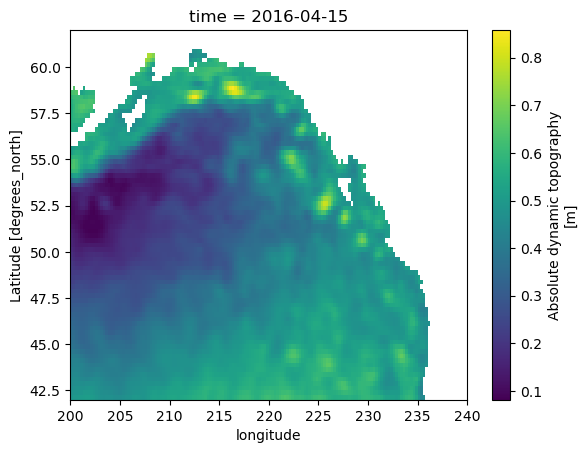

In [52]:
# --------------------------------------------------------
# select date and domain of the altimetry data
# display the analysis domain
# --------------------------------------------------------
ds=xr.open_dataset('cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2016.nc')
ds1=ds.sel(time=date,method='nearest')
x=ds['longitude']+360
ds1['longitude']=x
ds2=ds1.sel(longitude=slice(extent[0],extent[1])).sel(latitude=slice(extent[2],extent[3]))
ds2.to_netcdf('ssh.nc')
ds2=xr.open_dataset('ssh.nc')
ds2.adt.plot()

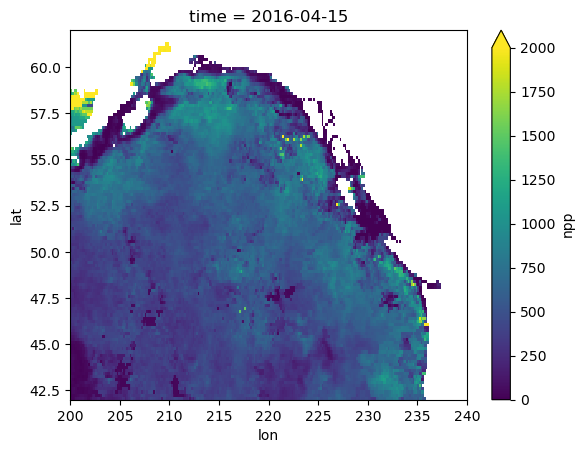

In [53]:
# --------------------------------------------------------
# select date and domain of the NPP data
# display the analysis domain
# --------------------------------------------------------
ds=xr.open_dataset('npp_CbPM-MODIS_8day_GOA.nc')
ds1=ds.sel(time=date,method='nearest')
x=ds1['lon'].to_numpy()+360
ds1['lon']=x
ds2=ds1.sel(lon=slice(extent[0],extent[1])).sel(lat=slice(extent[2],extent[3]))
ds2.to_netcdf('npp.nc')
ds2=xr.open_dataset('npp.nc')
ds2.npp.plot(vmin=0,vmax=2000)

In [54]:
# --------------------------------------------------------
# import necessary packages
# --------------------------------------------------------
from matplotlib import pyplot as plt
from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
filename_alt = "ssh.nc"
filename_npp = "npp.nc"
var_name_npp = "npp"

## Loading data



In [55]:
# --------------------------------------------------------
# read in the data using 'RegularGridDataset' 
# --------------------------------------------------------
npp = RegularGridDataset(filename=filename_npp, x_name="lon", y_name="lat", nan_masking=True,)
alti = RegularGridDataset(filename=filename_alt, x_name="longitude", y_name="latitude", nan_masking=True,)
# --------------------------------------------------------
# We can use `Grid` tools, 'regrid' method to interpolate ADT on the sst grid
# This step combines altimetry data into NPP gridded dataset
# --------------------------------------------------------
npp.regrid(alti, "adt")
# This step calculate geostrophic circulation based on altimetry data
npp.add_uv("adt")

We assume pixel position of grid is centered for npp.nc
We assume pixel position of grid is centered for ssh.nc


Functions to initiate figure axes



In [56]:
# ---------------------------------------------------------------
# these are helper functions for setting up the plot efficiently
# ---------------------------------------------------------------
def start_axes(title, extent=extent):
    fig = plt.figure(figsize=(13, 6), dpi=120)
    ax = fig.add_axes([0.03, 0.05, 0.89, 0.91])
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_title(title)
    ax.set_aspect("equal")
    return ax
def update_axes(ax, mappable=None, unit=""):
    ax.grid()
    if mappable:
        cax = ax.figure.add_axes([0.93, 0.05, 0.01, 0.9], title=unit)
        plt.colorbar(mappable, cax=cax)

## ADT = absolute dynamic topography, display
    - Use the helper functions

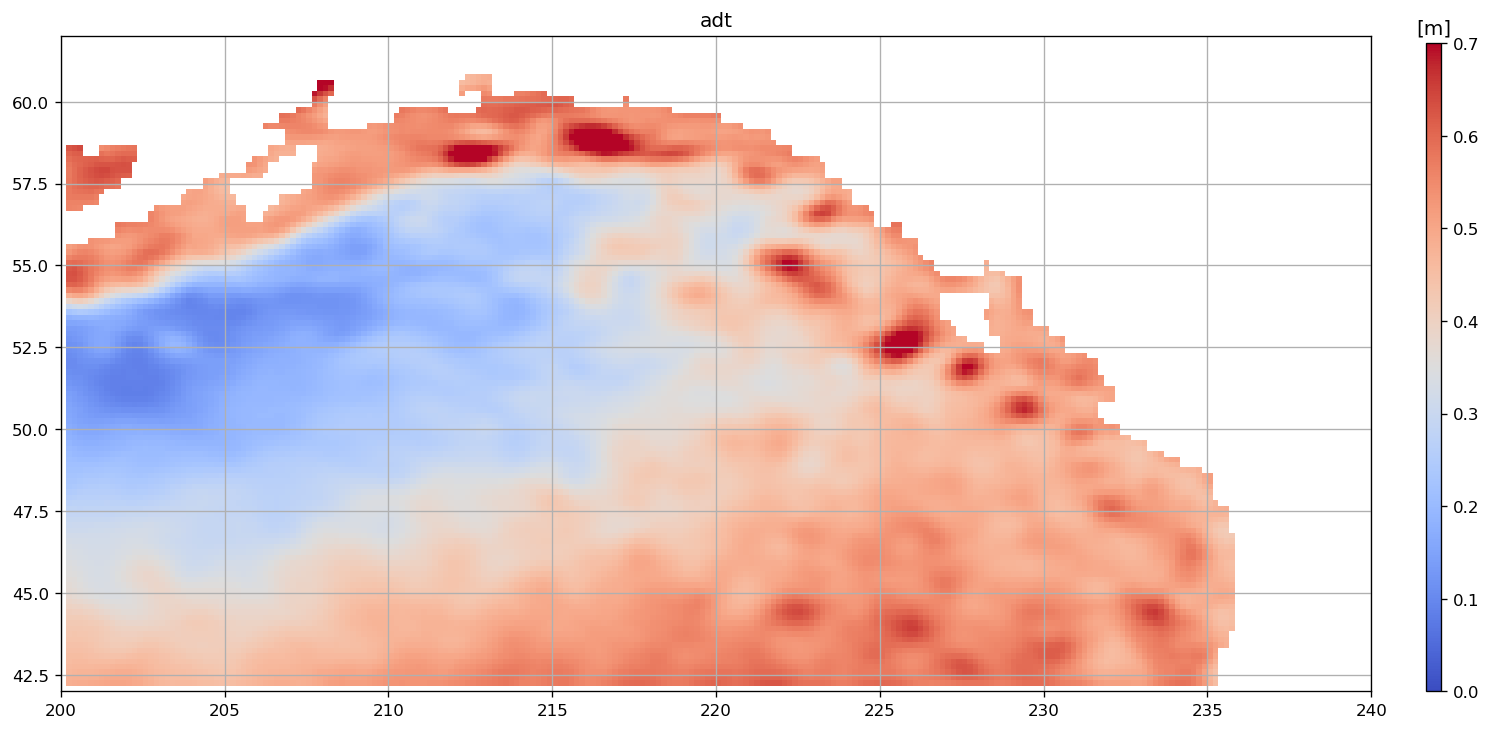

In [57]:
ax = start_axes("adt", extent=extent)
m = npp.display(ax, "adt", vmin=0, vmax=.7)
update_axes(ax, m, unit="[m]")

## NPP display



We can now plot NPP from `npp`



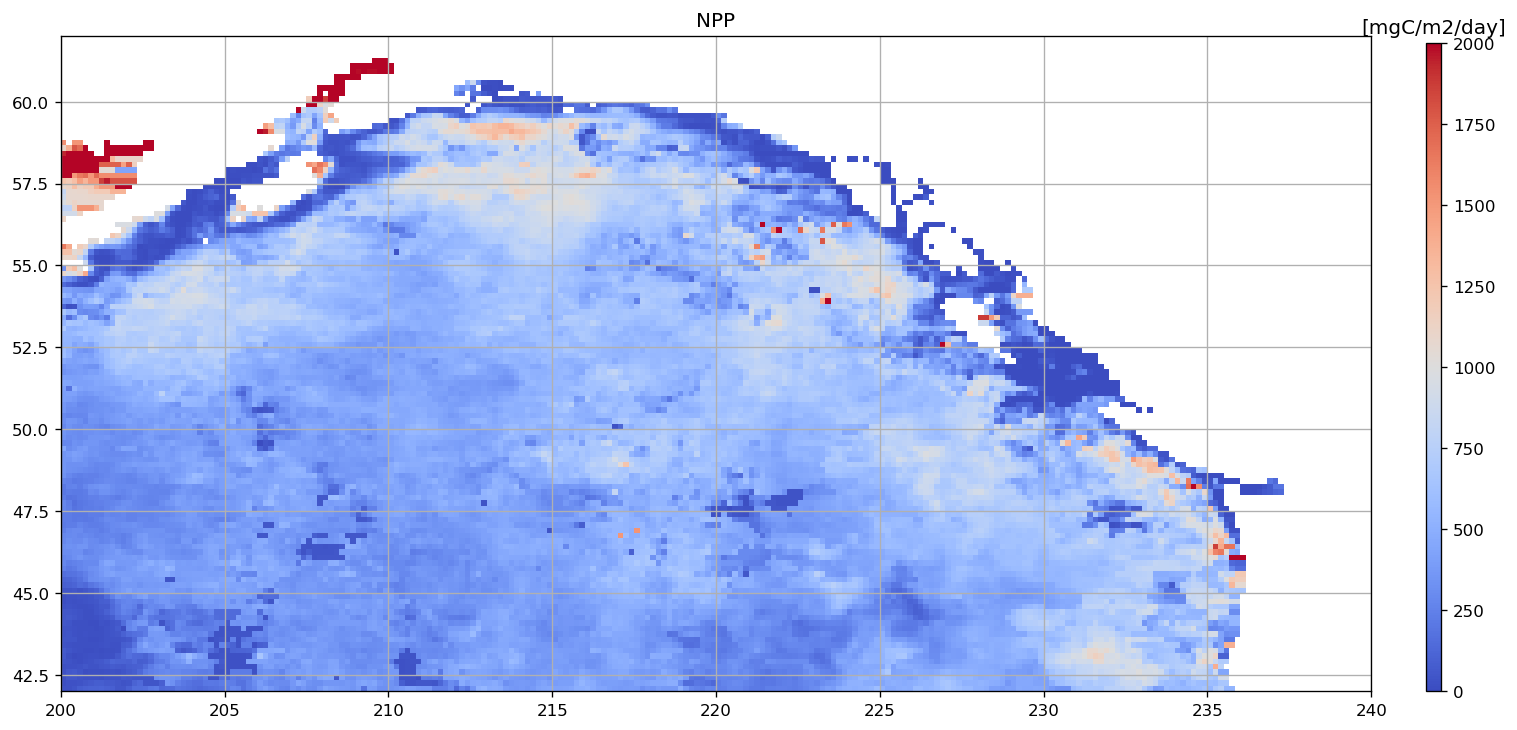

In [58]:
ax = start_axes("NPP")
m = npp.display(ax, "npp", vmin=0, vmax=2000)
update_axes(ax, m, unit="[mgC/m2/day]")

### Overlay the circulation field (calculated from ADT) on top of the NPP field

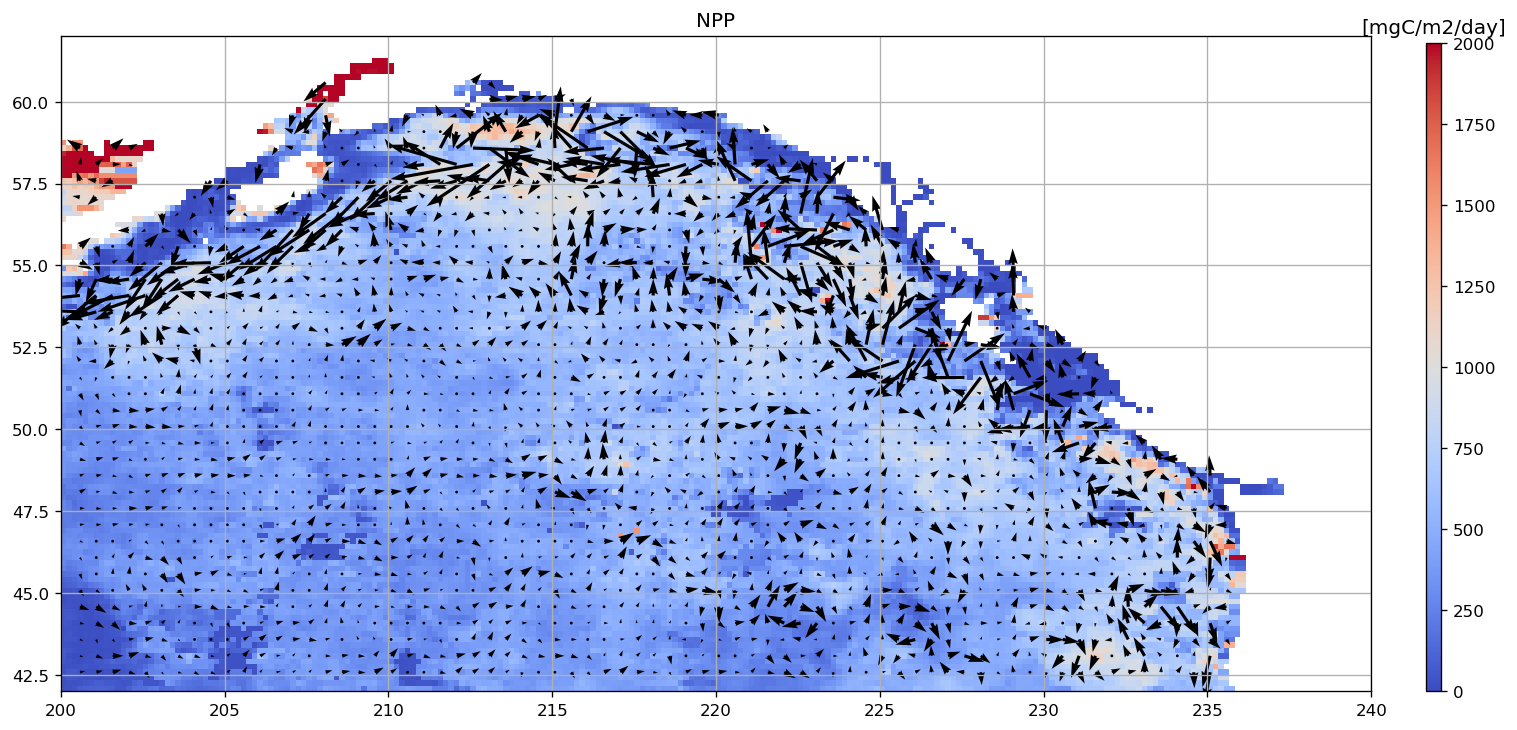

In [59]:
st = 3
ax = start_axes("NPP")
m = npp.display(ax, "npp", vmin=0, vmax=2000)
u, v = npp.grid("u").T, npp.grid("v").T
ax.quiver(npp.x_c[::st], npp.y_c[::st], u[::st, ::st], v[::st, ::st], scale=10)
update_axes(ax, m, unit="[mgC/m2/day]")

Now, with eddy contours, and displaying SST anomaly



In [60]:
# ------------------------------------------------------------
# Apply spatial filter to select for the small scale features
# number is in the units of km
# ------------------------------------------------------------
npp.bessel_high_filter("npp", 300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


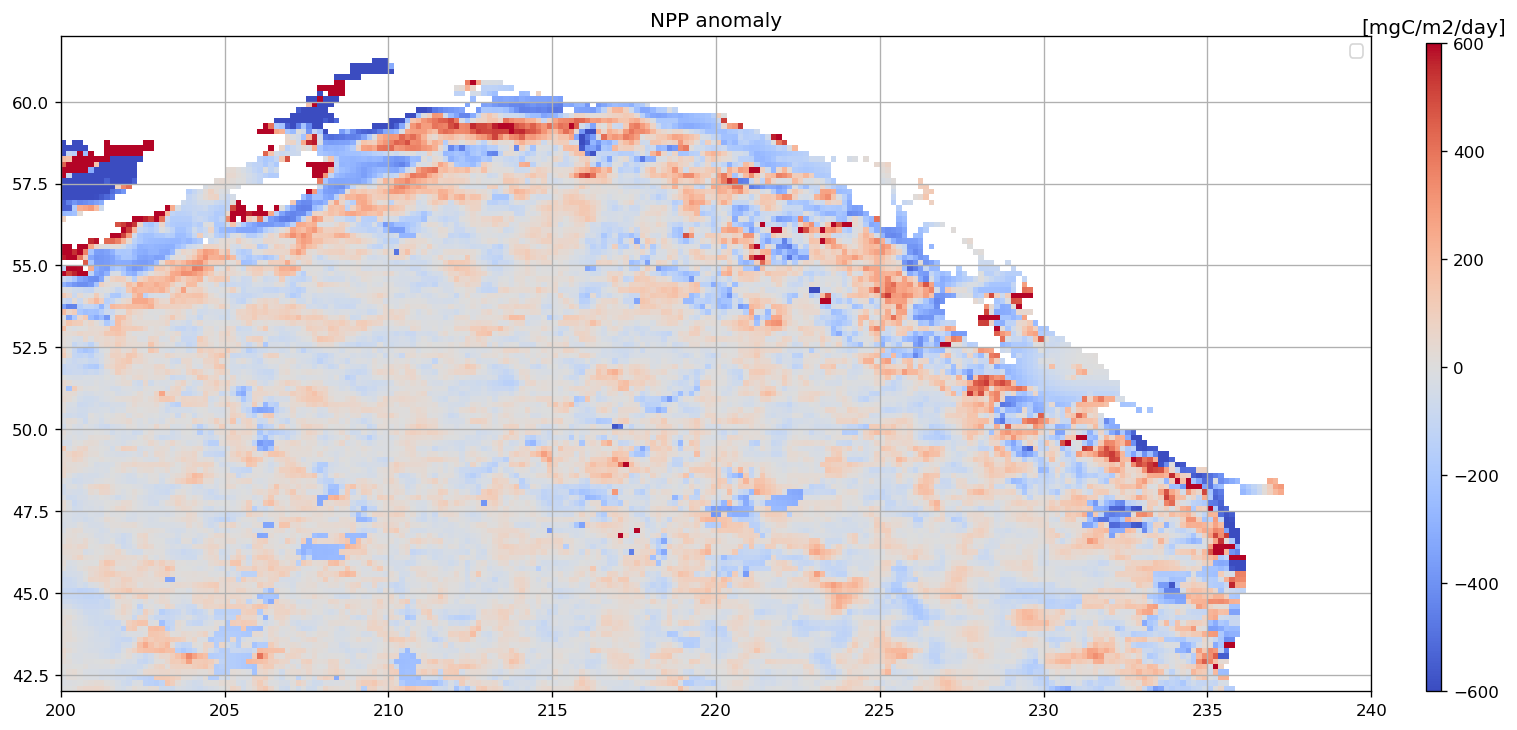

In [61]:
ax = start_axes("NPP anomaly")
m = npp.display(ax, "npp", vmin=-600, vmax=600)
#m = npp.display(ax, "npp", vmin=0, vmax=2000)
ax.legend()
#ax.quiver(npp.x_c[::st], npp.y_c[::st], u[::st, ::st], v[::st, ::st], scale=10)
update_axes(ax, m, unit="[mgC/m2/day]")

## Eddy detection



In [62]:
npp.bessel_high_filter("adt", 300)

/Users/takamitsu3/opt/anaconda3/envs/REU2023/lib/python3.10/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


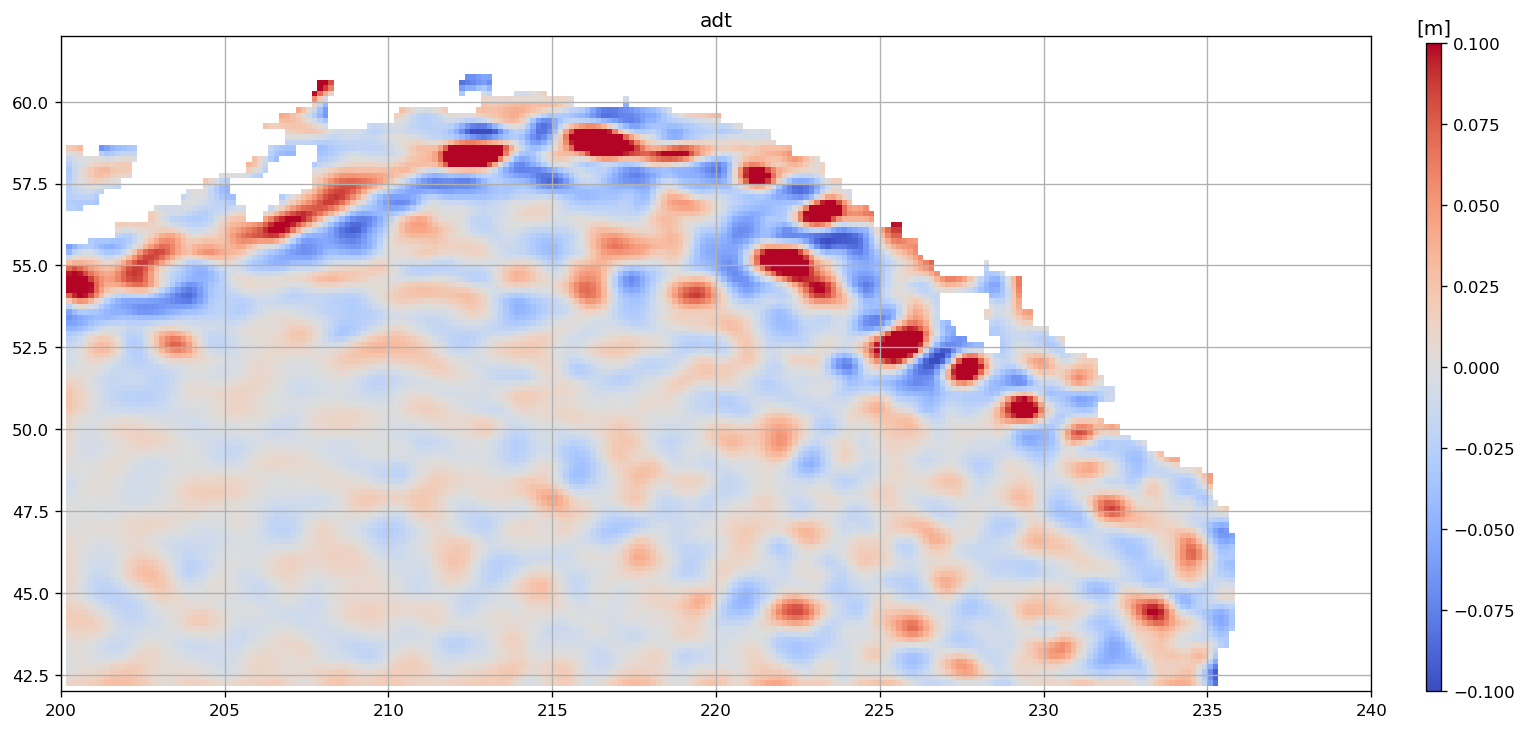

In [63]:
# ADT filtered
ax = start_axes("adt", extent=extent)
m = npp.display(ax, "adt", vmin=-0.1, vmax=0.1)
update_axes(ax, m, unit="[m]")
# -----------------------------------------------------------
# The eddy detection takes ssh, u, v velocities as input
#  additional input is date and step between two layers
# -----------------------------------------------------------
a, c = npp.eddy_identification("adt", "u", "v", date, 0.01)

In [64]:
kwargs_a = dict(lw=2, label="Anticyclonic", ref=-10, color="b")
kwargs_c = dict(lw=2, label="Cyclonic", ref=-10, color="r")

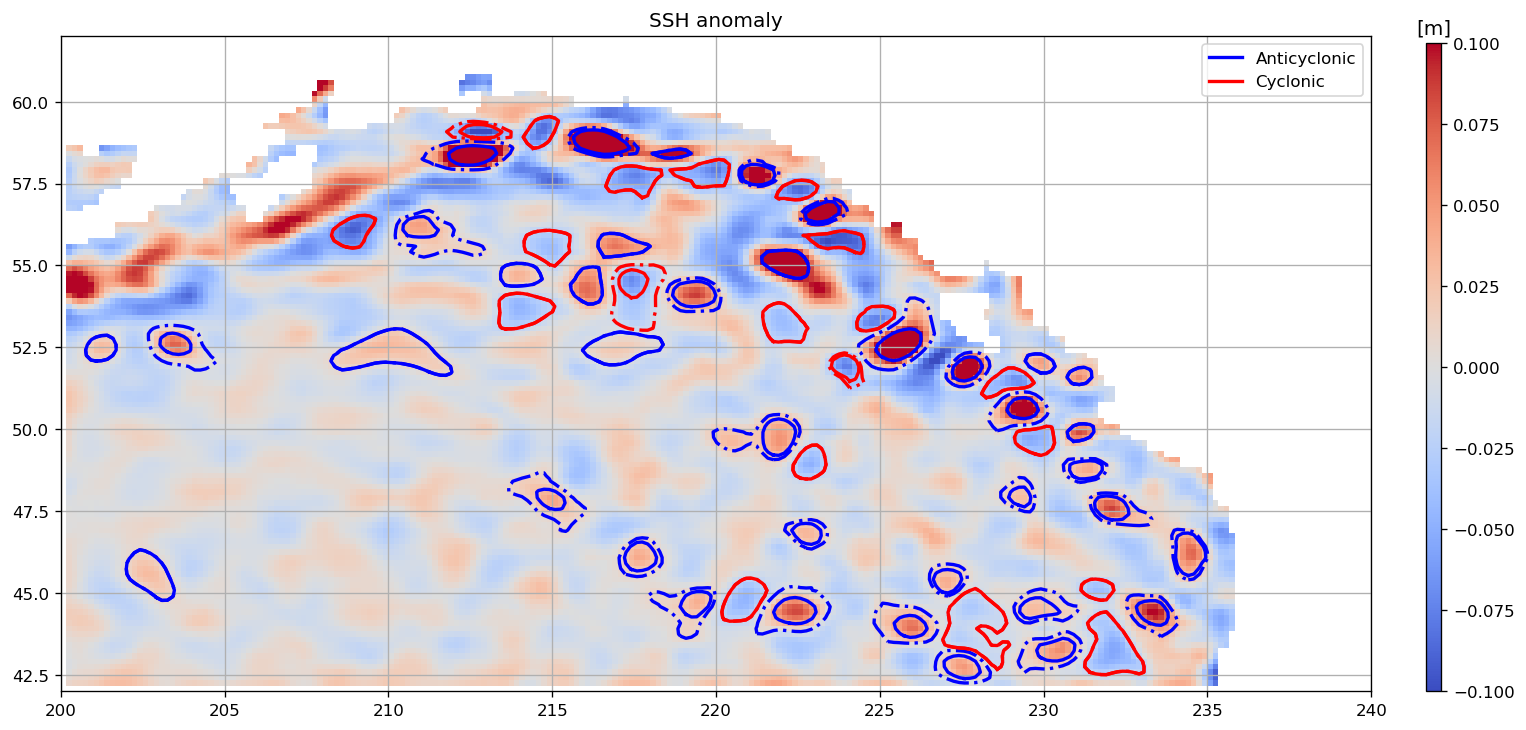

In [65]:
ax = start_axes("SSH anomaly")
m = npp.display(ax, "adt", vmin=-.1, vmax=.1)
a.display(ax, **kwargs_a), c.display(ax, **kwargs_c)
ax.legend()
update_axes(ax, m, unit="[m]")

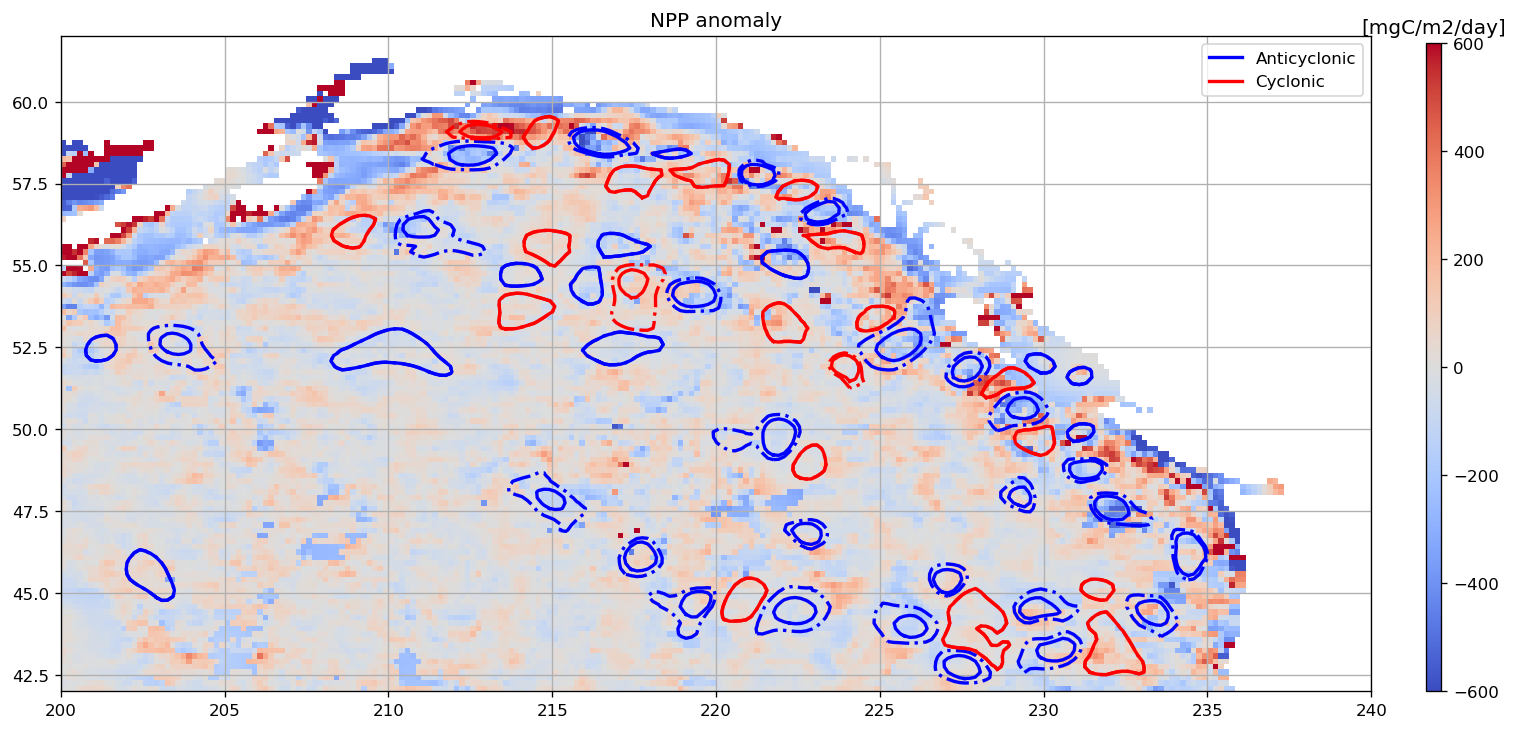

In [66]:
ax = start_axes("NPP anomaly")
m = npp.display(ax, "npp", vmin=-600, vmax=600)
#m = npp.display(ax, "npp", vmin=0, vmax=2000)
a.display(ax, **kwargs_a), c.display(ax, **kwargs_c)
ax.legend()
update_axes(ax, m, unit="[mgC/m2/day]")

## Example of post-processing
Get mean of npp anomaly_high in each internal contour



In [67]:
anom_a = a.interp_grid(npp, "npp", method="mean", intern=True)
anom_c = c.interp_grid(npp, "npp", method="mean", intern=True)

Are cyclonic (resp. anticyclonic) eddies generally associated with positive (resp. negative) NPP anomaly ?



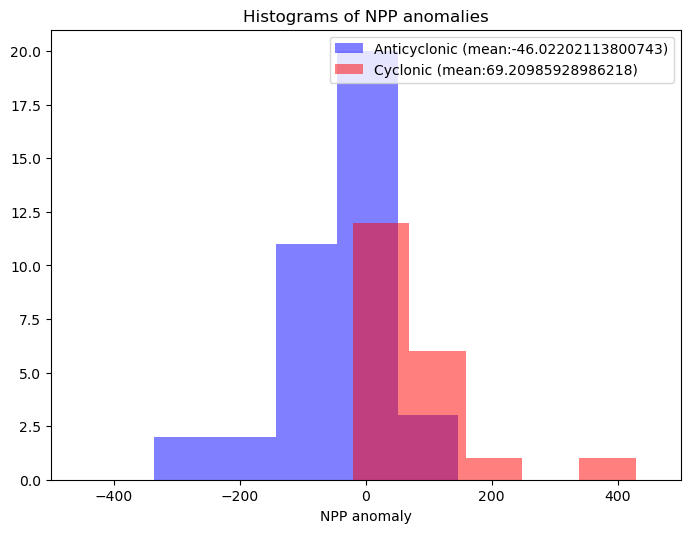

In [68]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0.05, 0.05, 0.90, 0.90])
ax.set_xlabel("NPP anomaly")
#ax.set_xlim([0, 2000])
ax.set_xlim([-500, 500])
ax.set_title("Histograms of NPP anomalies")
ax.hist(
    anom_a, 5, alpha=.5, color="b", label="Anticyclonic (mean:%s)" % (anom_a.mean())
)
ax.hist(anom_c, 5, alpha=.5, color="r", label="Cyclonic (mean:%s)" % (anom_c.mean()))
ax.legend()

## Statsitical test (t-test)

### [1] Does ocean eddies play significant roles in biological productivity?
    - H0 there is no significant difference in NPP between the areas within eddies and the background. 
    - H1 there is significant difference in NPP
    - We perform this analysis separately for cyclonic and anticyclonic eddies

### [2] How important is the type of eddies (cyclonic vs anticyclonic)?
    - H0 there is no significant difference in NPP between cyclonic and anticyclonic eddies
    - H1 there is significant difference in NPP
    
    - For all analyses, we use 95% confidence interval (two tail test)

In [69]:
# 1. calculate the signal for cyclonic eddies
npp_c = anom_c.mean()
print('average NPP within cyclone = '+str(round(npp_c,3))+' mgC/m2/day')
# 
# calculate standard error
#
npp_c_stdev = anom_c.std()
print('stdev of NPP within cyclone = '+str(round(npp_c_stdev,3))+' mgC/m2/day')
# 
N_c = np.size(anom_c)
print(f'there are {N_c} cyclonic eddies present in this data')
# calculate standard error
SE = npp_c_stdev*np.sqrt(1/N_c)
print('standard error is '+str(round(SE,3))+' mgC/m2/day')
#
# calculate t statistic
tval = npp_c/SE
print('t-value of the signal is '+str(abs(tval)))
#
# calculate the critical t-value
from scipy import stats
tcrit = stats.t.ppf(.975,N_c-1)
print('critical t-value is '+str(tcrit))

average NPP within cyclone = 69.21 mgC/m2/day
stdev of NPP within cyclone = 102.799 mgC/m2/day
there are 20 cyclonic eddies present in this data
standard error is 22.987 mgC/m2/day
t-value of the signal is 3.0108712718638126
critical t-value is 2.093024054408263


In [70]:
# 2. calculate the signal for anti-cyclonic eddies
npp_a = anom_a.mean()
print('average NPP within anticyclone = '+str(round(npp_a,3))+' mgC/m2/day')
# 
# calculate standard error
#
npp_a_stdev = anom_a.std()
print('stdev of NPP within anticyclone = '+str(round(npp_a_stdev,3))+' mgC/m2/day')
# 
N_a = np.size(anom_a)
print(f'there are {N_a} anticyclonic eddies present in this data')
# calculate standard error
SE = npp_a_stdev*np.sqrt(1/N_a)
print('standard error is '+str(round(SE,3))+' mgC/m2/day')
#
# calculate t statistic
tval = npp_a/SE
print('t-value of the signal is '+str(abs(tval)))
#
# calculate the critical t-value
from scipy import stats
tcrit = stats.t.ppf(.975,N_a-1)
print('critical t-value is '+str(tcrit))

average NPP within anticyclone = -46.022 mgC/m2/day
stdev of NPP within anticyclone = 95.256 mgC/m2/day
there are 38 anticyclonic eddies present in this data
standard error is 15.453 mgC/m2/day
t-value of the signal is 2.9782770977374473
critical t-value is 2.0261924630291093


In [71]:
# calculate the difference between cyclonic and anticyclonic eddies as the signal
npp_a = anom_a.mean()
print('average NPP within anticyclone = '+str(round(npp_a,3))+' mgC/m2/day')
npp_c = anom_c.mean()
print('average NPP within cyclone = '+str(round(npp_c,3))+' mgC/m2/day')
# 
signal_cma = npp_c - npp_a
# 
# calculate standard error
#
npp_a_stdev = anom_a.std()
print('stdev of NPP within anticyclone = '+str(round(npp_a_stdev,3))+' mgC/m2/day')
npp_c_stdev = anom_c.std()
print('stdev of NPP within cyclone = '+str(round(npp_c_stdev,3))+' mgC/m2/day')
# 
# combined standard deviation
N_a = np.size(anom_a)
N_c = np.size(anom_c)
print('there are '+str(N_a)+' anticyclones and '+str(N_c)+' cyclones')
npp_stdev = np.sqrt( ((N_a-1)*npp_a_stdev**2 + (N_c-1)*npp_c_stdev**2)/(N_a+N_c-2) )
print('combined stdev is '+str(round(npp_stdev,3))+' mgC/m2/day')
# 
# calculate standard error
SE = npp_stdev*np.sqrt(1/N_a+1/N_c)
print('standard error is '+str(round(SE,3))+' mgC/m2/day')
#
# calculate t statistic
tval = signal_cma/SE
print('t-value of the signal is '+str(abs(tval)))
#
# calculate the critical t-value
from scipy import stats
tcrit = stats.t.ppf(.975,N_a+N_c-2)
print('critical t-value is '+str(tcrit))

average NPP within anticyclone = -46.022 mgC/m2/day
average NPP within cyclone = 69.21 mgC/m2/day
stdev of NPP within anticyclone = 95.256 mgC/m2/day
stdev of NPP within cyclone = 102.799 mgC/m2/day
there are 38 anticyclones and 20 cyclones
combined stdev is 97.881 mgC/m2/day
standard error is 27.04 mgC/m2/day
t-value of the signal is 4.2615633092786895
critical t-value is 2.0032407174966975
